# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

## Task:
- Quadratic function
- Normal noise
- Anomalies
- Anomalies detection
- LSM

## Imports

In [318]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Config

In [319]:
np.random.seed(1)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

## Parameters

In [320]:
PARAM_selection_size = 1000
PARAM_anomaly_size = int(0.1 * PARAM_selection_size)
PARAM_widnow_size = int(0.1 * PARAM_selection_size)

PARAM_normal_mean = 0
PARAM_normal_std = 5

PARAM_max_test_pow = 11

## Functions

In [321]:
def describe_all(_data, trend_column):
    """Prints stats of all data in dictionary"""
    # create df
    df = pd.DataFrame(_data)
    # remove trend from other data
    trend_data = df[trend_column].copy()
    for column in df.columns:
            df[column] = df[column] - trend_data
    # find stats and calc var
    stats = df.describe()
    stats.loc["var"] = stats.loc["std"] ** 2
    return stats

In [322]:
def lsm(y, pol_pow):
    """
    LSM
    y - 1d array of values,
    pol_pow - polynomial power of model
    """
    # Reshape y to row vector
    Y = y.reshape(-1, 1)
    # Creating F matrix, 1, x, x^2, ..., x^PARAM_max_pow
    F = np.ones((len(y), pol_pow + 1))
    for i in range(1, pol_pow + 1):
        # pow
        F[:, i] = np.power(np.arange(0, len(y)), i)
    # calculations
    FT = F.T
    FF = np.dot(FT, F)
    FFI = np.linalg.inv(FF)
    FFIFT = np.dot(FFI, FT)
    C = np.dot(FFIFT, Y)
    result = np.dot(F, C)
    # returning array, reshaped from row vector to 1d
    return result.reshape(-1)

## Errors and anomalies

In [323]:
# normal error
_normal = np.random.normal(PARAM_normal_mean, PARAM_normal_std, PARAM_selection_size)

# adding anomalies at indexes, drawn from uniform distribution
# starting from PARAM_widnows_size to get std of normal error without anomalies
# (instead of manually removing anomalies from first window)
_normal_anomalies = _normal.copy()
for i in np.unique(np.random.randint(PARAM_widnow_size, PARAM_selection_size, PARAM_anomaly_size)):
    while abs(_normal_anomalies[i]) < _normal.std() * 3:
        _normal_anomalies[i] *= 2

## Data

In [324]:
data = {}

# quadratic, + noise, + anomalies
data["quadratic"] = np.square(np.linspace(0, 10, PARAM_selection_size))
data["quadratic_normal"] = data["quadratic"].copy() + _normal
data["quadratic_normal_anomalies"] = data["quadratic"].copy() + _normal_anomalies

describe_all(data, "quadratic")

,quadratic,quadratic_normal,quadratic_normal_anomalies
count,"1,000.000","1,000.000","1,000.000"
mean,0.000,0.194,0.146
std,0.000,4.907,8.125
min,0.000,-15.269,-29.405
25%,0.000,-3.001,-3.332
50%,0.000,0.206,0.226
75%,0.000,3.520,3.924
max,0.000,19.793,29.218
var,0.000,24.083,66.022


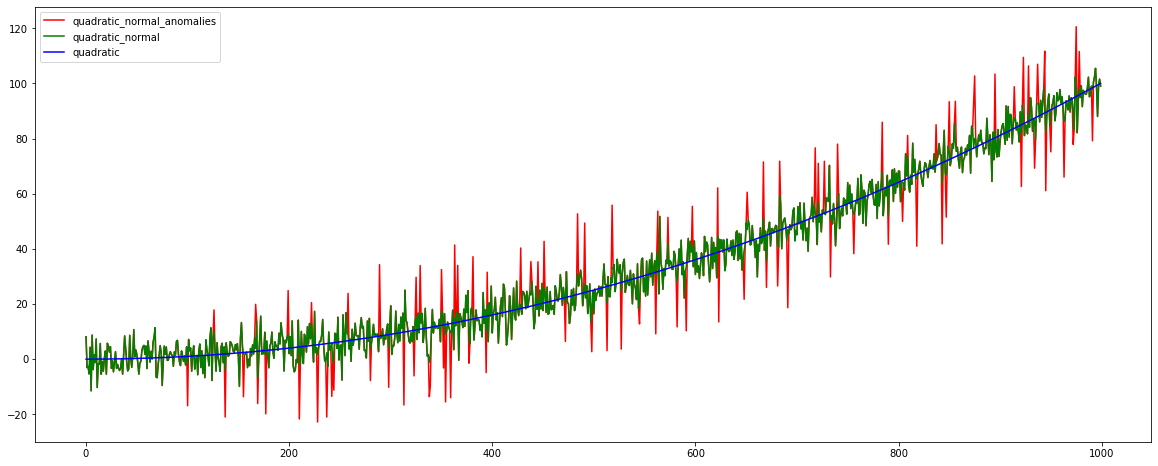

In [325]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies", c="red")
plt.plot(data["quadratic_normal"], label="quadratic_normal", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.legend()
plt.show()

## Finding optimal polynomial power for smoothing

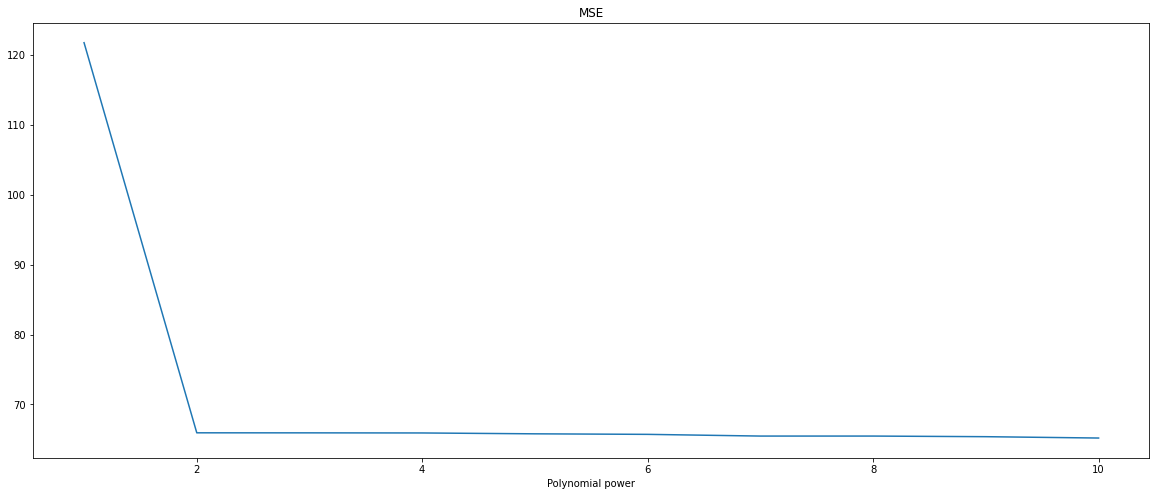

In [326]:
errs = []
pow_range = range(1, PARAM_max_test_pow)
for power in pow_range:
    errs.append((np.square(data["quadratic_normal_anomalies"] - lsm(data["quadratic_normal_anomalies"], power))).mean())

plt.title("MSE")
plt.xlabel("Polynomial power")
plt.plot(pow_range, errs)
plt.show()

In [327]:
PARAM_best_pow = 2

## Detecting Anomalies with Sliding Window

In [328]:
data["quadratic_normal_anomalies_fix"] = data["quadratic_normal_anomalies"].copy()
window = data["quadratic_normal_anomalies_fix"][:PARAM_widnow_size]

std3 = 3 * abs((window - lsm(window, PARAM_best_pow)).std())
print("Estimated 3*std:", std3)

Estimated 3*std: 13.16583142755934


In [329]:
# save indexes and values of anomalies
anomaly_index = []
anomaly_value = []

for i in range(1, PARAM_selection_size - PARAM_widnow_size - 1):
    # new window
    widnow = data["quadratic_normal_anomalies"][i:(PARAM_widnow_size + i)]
    # new fit to window
    window_lsm = lsm(widnow, PARAM_best_pow)
    if abs((widnow - window_lsm)[-1]) > std3:
        anomaly_index.append(PARAM_widnow_size + i - 1)
        anomaly_value.append(widnow[-1])
        data["quadratic_normal_anomalies_fix"][PARAM_widnow_size + i - 1] = \
            (data["quadratic_normal_anomalies_fix"][PARAM_widnow_size + i - 2] \
                + data["quadratic_normal_anomalies_fix"][PARAM_widnow_size + i]) \
                    / 2

## Detected anomalies

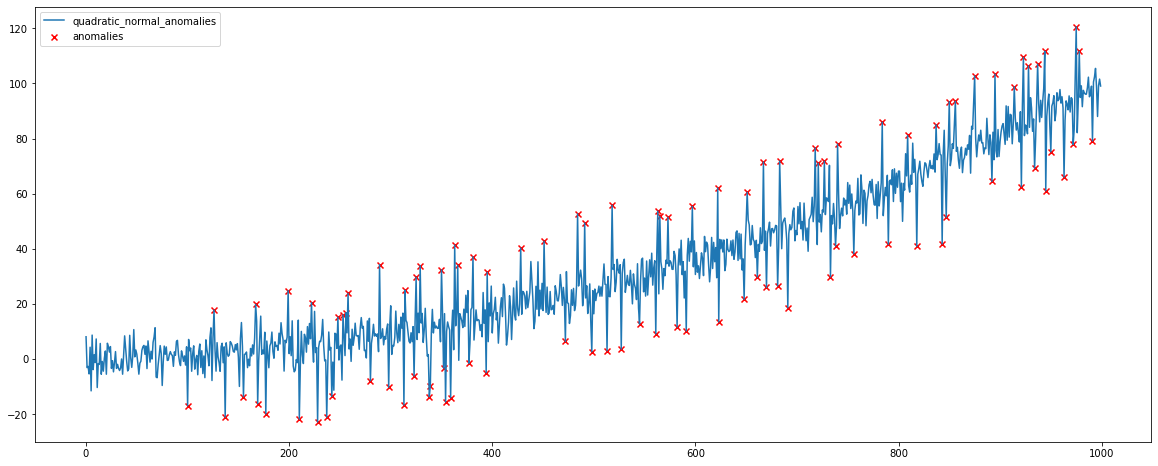

In [330]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies")
plt.scatter(anomaly_index, anomaly_value, label="anomalies", marker="x", c="red")
plt.legend()
plt.show()

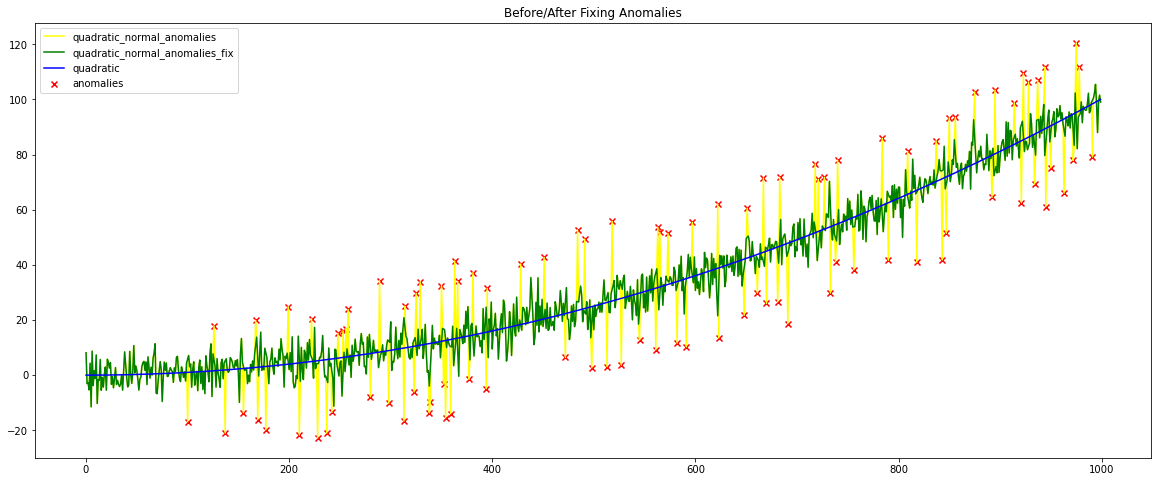

In [331]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies", c="yellow")
plt.plot(data["quadratic_normal_anomalies_fix"], label="quadratic_normal_anomalies_fix", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.scatter(anomaly_index, anomaly_value, label="anomalies", marker="x", c="red")
plt.title("Before/After Fixing Anomalies")
plt.legend()
plt.show()

## Smoothing Data without Anomalies Using LSM

In [332]:
data["quadratic_normal_anomalies_fix_lsm"] = lsm(data["quadratic_normal_anomalies_fix"], PARAM_best_pow)
describe_all(data, "quadratic")

,quadratic,quadratic_normal,quadratic_normal_anomalies,quadratic_normal_anomalies_fix,quadratic_normal_anomalies_fix_lsm
count,"1,000.000","1,000.000","1,000.000","1,000.000","1,000.000"
mean,0.000,0.194,0.146,0.181,0.181
std,0.000,4.907,8.125,4.888,0.105
min,0.000,-15.269,-29.405,-17.254,0.087
25%,0.000,-3.001,-3.332,-2.979,0.097
50%,0.000,0.206,0.226,0.206,0.127
75%,0.000,3.520,3.924,3.422,0.248
max,0.000,19.793,29.218,16.605,0.449
var,0.000,24.083,66.022,23.888,0.011


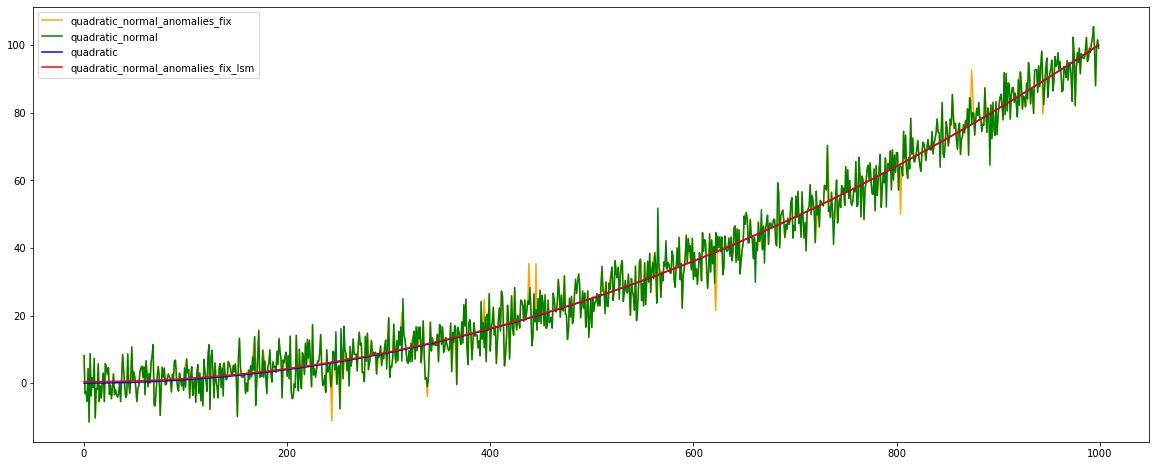

In [333]:
plt.plot(data["quadratic_normal_anomalies_fix"], label="quadratic_normal_anomalies_fix", c="orange")
plt.plot(data["quadratic_normal"], label="quadratic_normal", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.plot(data["quadratic_normal_anomalies_fix_lsm"], label="quadratic_normal_anomalies_fix_lsm", c="red")
plt.legend()
plt.show()

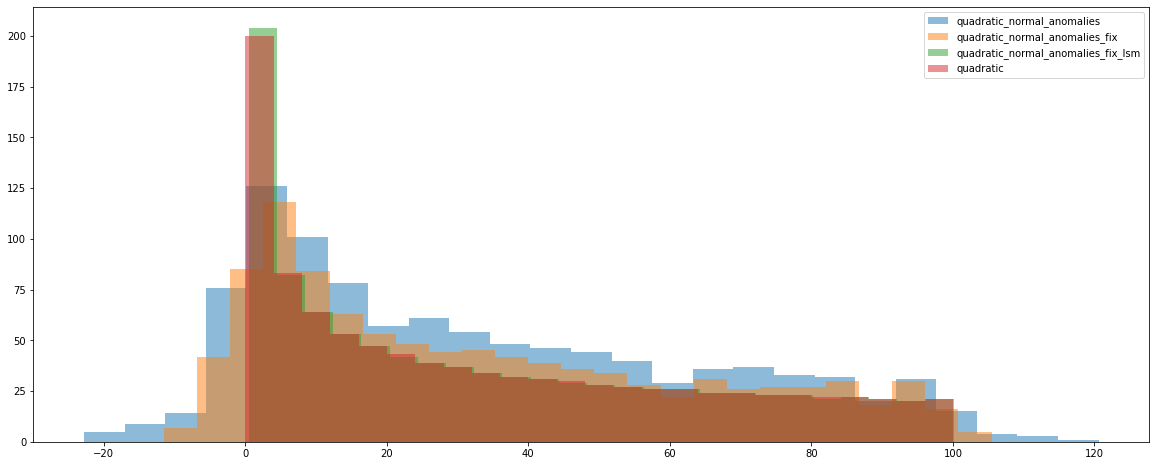

In [334]:
plt.hist(data["quadratic_normal_anomalies"], bins=25, alpha=0.5, label="quadratic_normal_anomalies")
plt.hist(data["quadratic_normal_anomalies_fix"], bins=25, alpha=0.5, label="quadratic_normal_anomalies_fix")
plt.hist(data["quadratic_normal_anomalies_fix_lsm"], bins=25, alpha=0.5, label="quadratic_normal_anomalies_fix_lsm")
plt.hist(data["quadratic"], bins=25, alpha=0.5, label="quadratic")
plt.legend()
plt.show()